# Classe pour le violon et exploration des descripteurs associés à l'instrument


### La transposition des descripteurs utiles pour la clarinette au violon nécessite davantage de discussion, mais c'est un premier pas
@author: Julien V

Une façon d'utiliser le code de Coline sur le violon et le code de Lalie sur les descripteurs

update 0.0: pour le moment, seul la force de l'archet est observée, on peut faire varier davantage de paramètres comme L, beta, tension de la corde

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os
from time import time
from numba import njit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os
from time import time

class SimulateurViolon:
    
    def __init__(self, T_sec=0.1, L=0.325, d=0.45e-3, Fb=0.2, vb=0.45, beta=5/16):
        """
        Paramètres physique du système
        """
        
        self.T_sec = T_sec                                             # Durée du signal (s)
        self.L = L                                                     # longueur de la corde (m)
        self.d = d                                                     # diamètre de la corde LA (m) 
        self.R = d/2                                                   # rayon de la corde (m)
        self.T_tension = 6*9.81                                        # Tension pour une corde de LA (N)
        self.Area = np.pi * self.R**2                                  # section de la corde (m^2)
        self.f0_vise = 440                                             # fréquence fondamentale visée (Hz)
        self.mu = self.T_tension/(2*self.f0_vise*self.L)**2            # masse linéique (kg/m)
        self.rho = self.mu / self.Area                                 # masse volumique (kg/m3)
        self.c = np.sqrt(self.T_tension/self.mu)                       # vitesse du son (m/s)
        self.Zc = self.rho*self.c*self.Area                            # fréquence fondamentale (Hz)
        self.Yc = 1/self.Zc                                            # impédance caractéristique (kg/s)
        self.Yc_half = self.Yc/ 2                                      # admittance caractéristique (s/kg)
        
        # Paramètres de l'archet:
        
        self.Fb = Fb                                                   # force de l'archet (N) -- valeur réaliste = < 5 N
        self.vb = vb                                                   # vitesse de l'archet (m/s) -- valeur réaliste < 0.5 m/s
        self.v0 = 0.05                                                 # paramètre de contrôle tenant compte des coeffs de viscosité dynamique et statique (m/s)
        self.beta = beta                                               # ratio du point de contact entre la corde et l'archet
        
        # Pramètres du corps du violon:
        # Valeurs numériques de Schelleng, The violin as a circuit, 1963
        
        self.f_T1 = 500                                                # fréquence de résonance du premier mode de table T1 (Hz)
        self.S = 1.76e8*10**(-3)                                       # raideur effective du corps du violon (N/m)
        self.M = 17.8e-3                                               # masse effective du corps du violon (kg)
        self.Q = 30                                                    # Facteur de qualité

        # Paramètres de simulation:
        
        self.L_L = self.L*self.beta                                    # longueur de la partie droite de la corde (m)
        self.L_R = self.L*(1-self.beta)                                # longueur de la partie droite de la corde (m)
        self.T_L = 2 * self.L_L/self.c                                 # temps de parcours d'un aller-retour sur la moitié gauche de la corde (s)
        self.T_R = 2 * self.L_R/self.c                                 # temps de parcours d'un aller-retour sur la moitié droite de la corde (s)
        self.delta_t = min(self.T_L, self.T_R)/128                     # pas de temps (s)
        
        # Pré-calcul pour les plots:
        
        self.q_vals_plot = np.linspace(self.vb-100, self.vb + 100, 10000)
        self.f_vals_plot = self.F(self.q_vals_plot)
        self.q_min = self.q_vals_plot[np.argmin(np.abs(self.f_vals_plot - 0.01*np.max(self.f_vals_plot)))]


    def reflexion_left(self, t):
        
        """
        Fonction de réflexion r(t), de la forme gaussienne,
        Prise en compte des réflexions multiples du chevalet par une queue décroissante.
        Compute la valeur de la fonction de réflexion 
        """
        
        width_T = 0.039
        T = self.T_L
        b = 4*np.log(2)/(width_T*T)**2
        r = np.exp(-b *(t-T)**2)
        
        w_T1 = 2*np.pi*self.f_T1
        sigma = np.sqrt(1/(2*b))
        T_start = T + 3*sigma
        istart = int(T_start/self.delta_t)
        amp = self.Yc**(-1)/(self.S * self.M)**(1/2)
        
        if istart < len(r):
            r[istart:] = amp * np.real(np.exp((1j * w_T1 - w_T1/(2*self.Q))*(t[istart:] - T)))
        
        A = np.sum(r)
        a = -1/A
        return a*r

    def reflexion_right(self, t):
        """
        Fonction de réflexion gaussienne
        Compute la valeur de la fonction de réflexion 
        """
        width_T = 0.039
        T = self.T_R
        b = 4 * np.log(2)/(width_T*T)**2
        gauss = np.exp(-b*(t-T)**2)
        A = np.sum(gauss)
        a = -1/A
        return a*gauss

    def F(self, q):
        """
        Compute la force transverse appliquée sur la corde au point de contact
        """
        return self.Fb * (self.vb-q)/self.v0/(1 +((self.vb -q)/self.v0)**2)

    def F_deriv(self, q):
        """
        Compute la dérivée de la caractéristique non linéaire
        """
        return -self.Fb / self.v0*(self.v0**2 -(self.vb- q)**2)/(self.v0**2 +(self.vb-q)**2)**2

    def func_Newton(self, q, params):
        """
        Méthode de Newton pour la détermination de zéros
        """
        q_iL, q_iR = params[0], params[1]
        return self.F(q) -1/self.Yc_half*(q-q_iL-q_iR)

    def func_deriv_Newton(self, q, params):
        """
        Dérivée de la fonction dont on veut trouver le zéro avec Newton
        """
        return self.F_deriv(q) -1/self.Yc_half

    def dichotomie(self, params, a, b, n, tol=1e-9):
        """
        Trouver l'abcisse m tel que func(m) = 0 par dichotomie
        """
        if self.func_Newton(a, params) * self.func_Newton(b, params) > 0:
            return (a+b)/2
        else:
            m = (a+b)/2
            while np.abs(a-b) > tol:
                if self.func_Newton(m, params) == 0.:
                    return m
                elif self.func_Newton(a, params)*self.func_Newton(m, params) > 0:
                    a = m
                else:
                    b = m
                m = (a+b)/2
            return m

    def intersections(self, q_iL, q_iR, n):
        """
        Trouver les intersections entre la courbe non linéaire et la droite
        """
        
        inter = np.zeros((3, 2))
        nb_inter = 0
        q_vals = np.linspace(self.q_min, self.vb + self.v0, 100)
        params = [q_iL, q_iR]
        for i in range(1, len(q_vals)):
            if self.func_Newton(q_vals[i-1], params)*self.func_Newton(q_vals[i], params) < 0:
                q_intersect = self.dichotomie(params, q_vals[i-1], q_vals[i], n)
                inter[nb_inter] = [q_intersect, self.F(q_intersect)]
                nb_inter += 1
        return inter, nb_inter

    def hysteresis(self, q_prev, state_prev, q_iL, q_iR, n):
        """
        Trouver q et f à l'instant n en prenant en compte l'hystérésis
        Avec une dichotomie = méthode un peu plus lente mais plus robuste et précise
        """
        
        intersect, nb_inter = self.intersections(q_iL, q_iR, n)
        if nb_inter == 0:
            return [0.0, 0.0], -1
        elif nb_inter == 1:
            state = 1 if np.abs(intersect[0, 0] - self.vb) <= self.v0 else -1
            return intersect[0], state
        else:
            if state_prev == -1:
                return intersect[0], -1
            else:
                return intersect[-1], 1


    def executer(self):
        """
        Trouve q et f à l'instant n en prenant en compte l'hystérésis
        Avec une dichotomie = méthode un peu plus lente mais plus robuste et précise
        """
        temps = np.arange(0., self.T_sec, self.delta_t)
        N = len(temps)
        state = np.zeros(N)
        state[0] = -1
        
        f, q, q_iL, q_iR = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
        
        Lwin_L = int(5 * self.T_L/self.delta_t)
        Lwin_R = int(5 * self.T_R/self.delta_t)
        
        t_L = np.arange(0, Lwin_L)*self.delta_t
        t_R = np.arange(0, Lwin_R)*self.delta_t
        
        r_L = self.reflexion_left(t_L)
        r_R = self.reflexion_right(t_R)
        
        r_L_reverse = r_L[::-1].copy()
        r_R_reverse = r_R[::-1].copy()
        
        outgoing_hist_left = np.zeros(Lwin_L)
        outgoing_hist_right = np.zeros(Lwin_R)
        
        for n in range(1, N):
            q_iL[n] = np.dot(r_L_reverse, outgoing_hist_left)
            q_iR[n] = np.dot(r_R_reverse, outgoing_hist_right)
            
            res, s = self.hysteresis(q[n-1], state[n-1], q_iL[n], q_iR[n], n)
            q[n], f[n] = res[0], res[1]
            state[n] = s
            
            w_new_left = q_iR[n]+self.Yc_half * f[n]
            w_new_right = q_iL[n]+self.Yc_half * f[n]
            
            outgoing_hist_left[:-1] = outgoing_hist_left[1:]
            outgoing_hist_left[-1] = w_new_left
            outgoing_hist_right[:-1] = outgoing_hist_right[1:]
            outgoing_hist_right[-1] = w_new_right
            
        return temps, t_L, t_R, f, q, q_iL, q_iR, r_L, r_R

    def plot(self, resultats):
        temps, t_L, t_R, f, q, q_iL, q_iR, r_L, r_R = resultats
        
        plt.figure()
        plt.plot(t_L, r_L, label='left')
        plt.plot(t_R, r_R, '--', label='right')
        plt.grid(); plt.legend(); plt.title("Fonctions de réflexion")
        
        plt.figure()
        plt.plot(self.q_vals_plot, self.f_vals_plot, 'k', lw=0.5)
        plt.scatter(q, f, s=2, c='tab:red')
        plt.xlim(self.q_min, self.vb + abs(self.q_min))
        plt.title("Parcours de la caractéristique NL")
        
        plt.figure(figsize=(10, 7))
        plt.subplot(311); plt.plot(temps, q); plt.ylabel("q"); plt.grid()
        plt.subplot(312); plt.plot(temps, f); plt.ylabel("f"); plt.grid()
        plt.subplot(313); plt.plot(temps, q_iL, label='q_iL'); plt.plot(temps, q_iR, '--', label='q_iR')
        plt.legend(); plt.grid(); plt.tight_layout()
        plt.show()



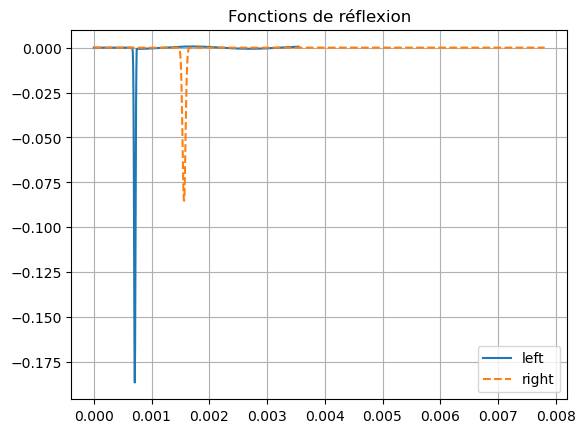

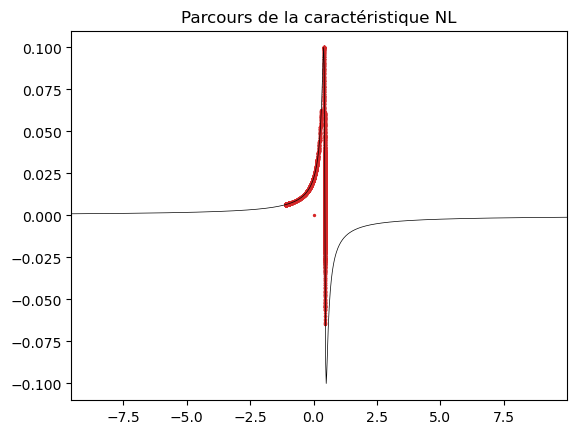

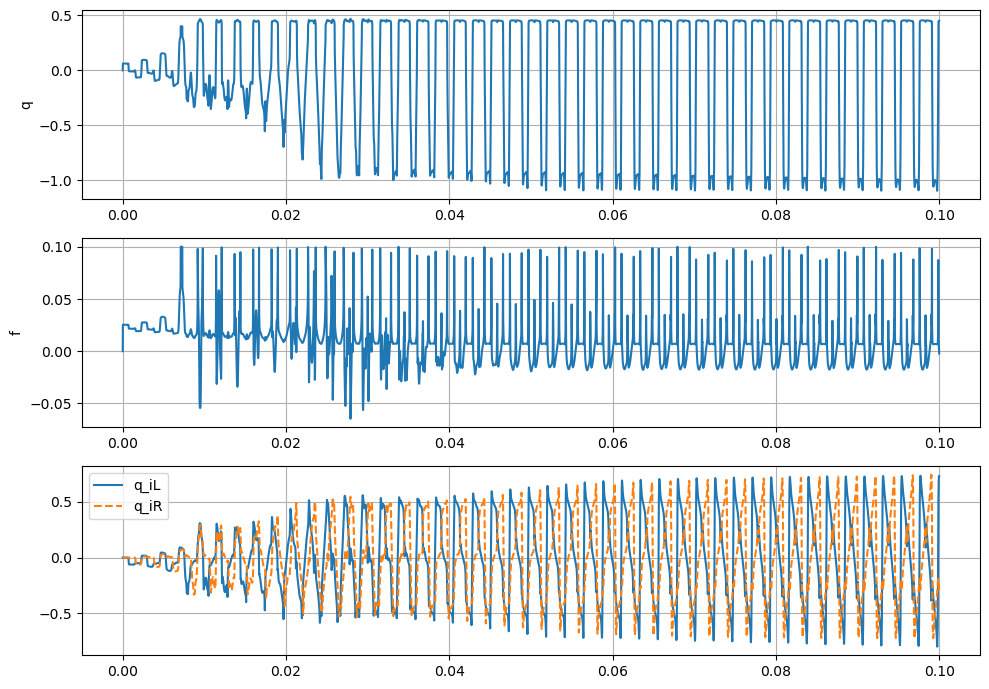

In [23]:
# Appel de la classe:

sim = SimulateurViolon(T_sec=0.1, Fb=0.2)
res = sim.executer()
sim.plot(res)

f est la force de frottement entre l'archet et la corde

q est la vitesse de la corde

# Partie Descripteur:

Je reprends le code de Lalie pour pouvoir comparer les résultats obtenus entre violon et clarinette

Ici du coup, on fait varier la force de l'archet Fb

In [25]:
class LatinSquare : 

    def __init__(self, n_data, u, dims = 2):
        from scipy.stats import qmc
        self.n_data = n_data
        self.u = u
        self.dims = dims
        self.sampler = qmc.LatinHypercube(self.dims)

    def indices(self) : 
        """
        Renvoie une liste d'indices suivant une distribution en carré latin
        """
        return self.sampler.integers(self.u, n=self.n_data)

In [34]:
Fb = np.linspace(0,1,100)

carre_latin = LatinSquare(n_data = 50, u = len(Fb) - 1)
indexes = carre_latin.indices()

c = 20.05*np.sqrt(273.15 + 20)
L = 0.325

temps, t_L, t_R, f, q, q_iL, q_iR, r_L, r_R = sim.executer()

In [35]:
# ici on approxime la pression de l'onde résultante par la vitesse de la corde q (grosse approximation)

def descripteur_son(P) : 
    N = len(P)
    N_tiers = N % 3
    P_tiers = P[2*N_tiers:]
    return np.mean(P_tiers)

def classifieur_son(D_son, eps1) : 
    c = 0 # classe du son, 0 si régime statique ou 1 si régime oscillant
    if D_son > eps1 : 
        c = 1 
    return c

In [36]:
D_son = np.zeros(len(indexes))

for i, index in enumerate(indexes): 
    print("epoch :", i, "/50")
    sim = SimulateurViolon(T_sec=0.1, Fb=index[0])
    temps, t_L, t_R, f, q, q_iL, q_iR, r_L, r_R = sim.executer()
    D_son[i] = descripteur_son(q)

epoch : 0 /50
epoch : 1 /50
epoch : 2 /50
epoch : 3 /50
epoch : 4 /50
epoch : 5 /50
epoch : 6 /50
epoch : 7 /50
epoch : 8 /50
epoch : 9 /50
epoch : 10 /50
epoch : 11 /50
epoch : 12 /50
epoch : 13 /50
epoch : 14 /50
epoch : 15 /50
epoch : 16 /50
epoch : 17 /50
epoch : 18 /50
epoch : 19 /50
epoch : 20 /50
epoch : 21 /50
epoch : 22 /50
epoch : 23 /50
epoch : 24 /50
epoch : 25 /50
epoch : 26 /50
epoch : 27 /50
epoch : 28 /50
epoch : 29 /50
epoch : 30 /50
epoch : 31 /50
epoch : 32 /50
epoch : 33 /50
epoch : 34 /50
epoch : 35 /50
epoch : 36 /50
epoch : 37 /50
epoch : 38 /50
epoch : 39 /50
epoch : 40 /50
epoch : 41 /50
epoch : 42 /50
epoch : 43 /50
epoch : 44 /50
epoch : 45 /50
epoch : 46 /50
epoch : 47 /50
epoch : 48 /50
epoch : 49 /50


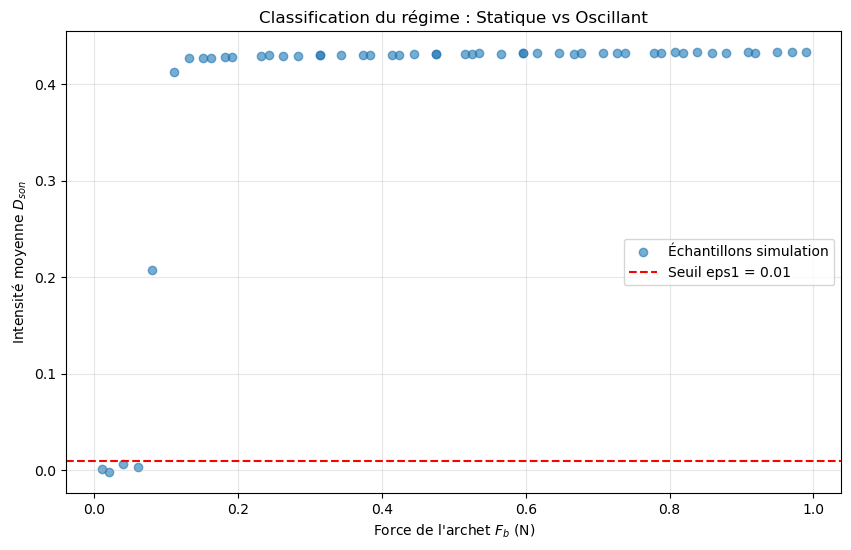

In [37]:
# visualisation:

eps1 = 0.01 # valeur seuil à ajuster/définir dans le cas de q
Fb_values = Fb[indexes[:, 0]]  # valeurs de Fb testées


plt.figure(figsize=(10, 6)) # (Fb , intensité)
plt.scatter(Fb_values, D_son, alpha=0.6, label="Échantillons simulation")

plt.axhline(y=eps1, color='r', linestyle='--', label=f"Seuil eps1 = {eps1}")

plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel(r"Intensité moyenne $D_{son}$")
plt.title("Classification du régime : Statique vs Oscillant")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 2eme descripteur: enveloppe de puissance

In [38]:
beta = 5/16
L_L = L*beta  
L_R = L*(1-beta)  
T_L = 2*L_L/c  
T_R = 2*L_R/c 
delta_t = min(T_L, T_R)/128

fs = 1/delta_t

0.00495600700378418 0.036351919174194336 0.00866389274597168


Text(0, 0.5, 'pwr')

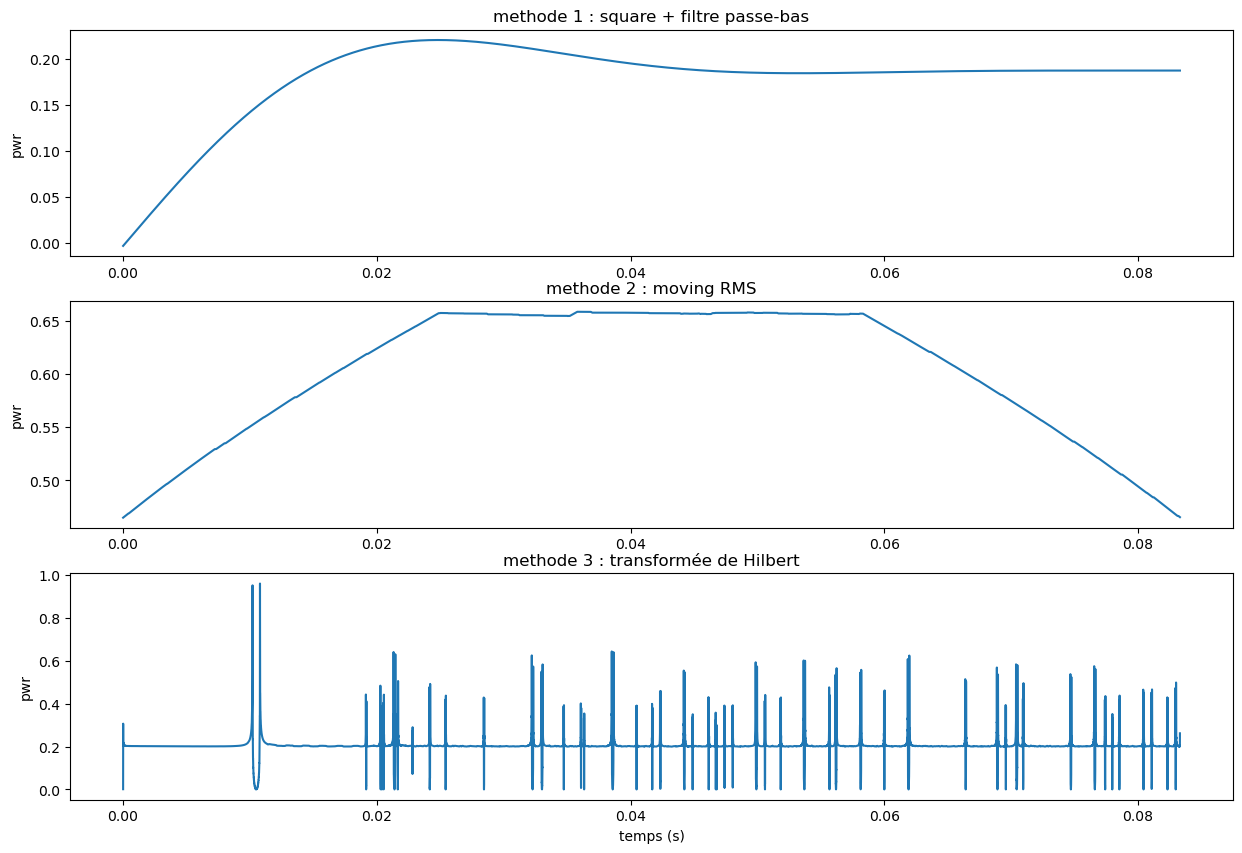

In [39]:
import time

# methode 1 : square + filtre passe-bas 
from scipy.signal import butter, filtfilt

start = time.time()

power = q**2
cutoff = 20  # enveloppe = ce qui varie lentement
b, a = butter(4, cutoff / (1 / (2*delta_t)), btype='low')
power_meth1 = filtfilt(b, a, power)
end = time.time()
temps1 = end - start

# methode 2 : moving RMS
window_ms = 50  # RMS window length
window_samples = int(fs * window_ms / 1000)
kernel = np.ones(window_samples) / window_samples
start = time.time()
power_meth2 = np.sqrt(np.convolve(q, kernel, mode='same'))
end = time.time()
temps2 = end - start

# methode 3 : transformée de Hilbert
from scipy.signal import hilbert

start = time.time()
analytic_signal = hilbert(q)
amplitude_envelope = np.abs(analytic_signal)
power_meth3 = amplitude_envelope**2
end = time.time()
temps3 = end - start

# plot
print(temps1, temps2, temps3)

plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(np.arange(len(power_meth1))*delta_t, power_meth1)
plt.title("methode 1 : square + filtre passe-bas")
plt.ylabel("pwr")
plt.subplot(312)
plt.plot(np.arange(len(power_meth2))*delta_t, power_meth2)
plt.title("methode 2 : moving RMS")
plt.ylabel("pwr")
plt.subplot(313)
plt.plot(np.arange(len(power_meth3))*delta_t, power_meth3)
plt.title("methode 3 : transformée de Hilbert")
plt.xlabel("temps (s)")
plt.ylabel("pwr")

In [40]:
from scipy.signal import butter, filtfilt

fs = 1/delta_t
cutoff = 20  # enveloppe = ce qui varie lentement
b, a = butter(4, cutoff / (fs / 2), btype='low')

def descripteur_regime(q, cutoff = 20, fs = 1/delta_t):
    power = q**2
    pwr = filtfilt(b, a, power)
    D_regime = np.var(pwr)/np.mean(pwr)
    return D_regime

# Détermination de $\epsilon_2$

dur = 0.5
D_regime = np.zeros(len(indexes))

for i, index in enumerate(indexes): 
    print("epoch :", i + 1, "/50")
    sim = SimulateurViolon(T_sec=0.1, Fb=index[0])
    temps, t_L, t_R, f, q, q_iL, q_iR, r_L, r_R = sim.executer()
    D_regime[i] = descripteur_regime(q)

epoch : 1 /50
epoch : 2 /50
epoch : 3 /50
epoch : 4 /50
epoch : 5 /50
epoch : 6 /50
epoch : 7 /50
epoch : 8 /50
epoch : 9 /50
epoch : 10 /50
epoch : 11 /50
epoch : 12 /50
epoch : 13 /50
epoch : 14 /50
epoch : 15 /50
epoch : 16 /50
epoch : 17 /50
epoch : 18 /50
epoch : 19 /50
epoch : 20 /50
epoch : 21 /50
epoch : 22 /50
epoch : 23 /50
epoch : 24 /50
epoch : 25 /50
epoch : 26 /50
epoch : 27 /50
epoch : 28 /50
epoch : 29 /50
epoch : 30 /50
epoch : 31 /50
epoch : 32 /50
epoch : 33 /50
epoch : 34 /50
epoch : 35 /50
epoch : 36 /50
epoch : 37 /50
epoch : 38 /50
epoch : 39 /50
epoch : 40 /50
epoch : 41 /50
epoch : 42 /50
epoch : 43 /50
epoch : 44 /50
epoch : 45 /50
epoch : 46 /50
epoch : 47 /50
epoch : 48 /50
epoch : 49 /50
epoch : 50 /50


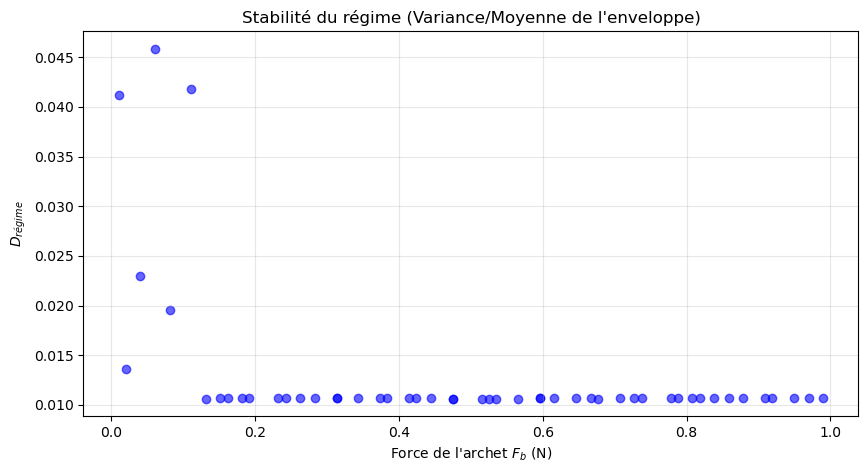

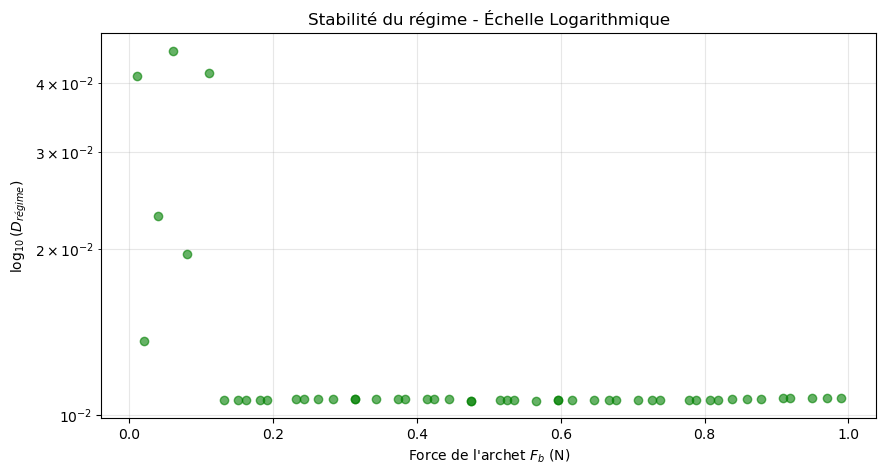

In [41]:
# Valeurs de Fb testées:

Fb_values = Fb[indexes[:, 0]]


plt.figure(figsize=(10, 5))
plt.scatter(Fb_values, D_regime, color='blue', alpha=0.6)
# plt.axhline(eps2, color="orange", linestyle="--", label="seuil de classification")
plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel(r"$D_{régime}$")
plt.title("Stabilité du régime (Variance/Moyenne de l'enveloppe)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot Semi-Log 
plt.figure(figsize=(10, 5))
plt.semilogy(Fb_values, D_regime, "go", alpha=0.6)
# plt.axhline(eps2, color="orange", linestyle="--", label="seuil de classification")
plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel(r"$\log_{10}(D_{régime})$")
plt.title("Stabilité du régime - Échelle Logarithmique")
plt.grid(True, which="both", alpha=0.3)
plt.show()

On cherche à minimiser la variance, si on a du chaos dans le signal "audible" alors D est grand, si le signal est stable alors on a D $\approx$ 0

# Justesse de la note

**Estimation de la fréquence fondamentale par la méthode du produit spectral** (source : TP TSM, Geoffroy Peeters)

Si nous notons $f_k = \frac{k}{N_{fft}}$ les fréquences discrètes de la DFT, le produit spectral est donné par:
\begin{equation}
    P(f_k) = \prod_{h=1}^{H} |X(h \cdot f_k)|
\end{equation}
Par défaut nous utiliserons $H$ = 4.

Détail des étapes de calcul :

Dans un premier temps, nous calculons la transformée de Fourier discrète (TFD) du signal $x(n)$ sur $N_{fft}$ points.
Nous commençons par multiplier $x(n)$ par une fenêtre de hamming de taille $L_n$ (ceci afin de diminuer la hauteur des lobes secondaires).

La longueur $L_n$ ainsi que le type de cette fenêtre détermine la **résolution fréquentielle**, i.e. le pouvoir de séparer en fréquence deux sinusoides adjacentes.

Le nombre de points de la la DFT, $N_{fft}$, détermine lui la **précision fréquentielle**., i.e. la distance en Hz entre $f_k$ et $f_{k+1}$.
Il faut impérativement utiliser une valeur de $N_{fft}$ supérieure à $L_n$. En pratique $N_{fft}$ est choisi comme une puissance de 2 de manière à pouvoir utiliser l'algorithme de FFT (Fast Fourier Transform). Ceci peut se calculer à l'aide de la fonction ```nextpow2```.

Calculer ensuite la transformée de Fourier Discrète $X(k)$.

In [42]:
class Classifier_justesse():
    def __init__(self, f_ref, eps3=5, delta_t=1e-5, L_sec=0.1, H=4, fmin=50, fmax=900):
        self.f_ref = f_ref
        self.eps3 = eps3 # cents
        self.fs = 1/delta_t
        self.L_sec = L_sec
        self.L_n = int(L_sec * self.fs)
        self.Nfft = 4 * self.nextpow2(self.L_n)
        self.H = H
        self.fmin = fmin
        self.fmax = fmax

    def nextpow2(self, i):
        n = 1
        while n < i: n *= 2
        return n
    
    def get_spectre(self, x):
        # On prend les L_n derniers points pour garantir la stabilité
        if len(x) < self.L_n:
            sig = np.pad(x, (0, self.L_n - len(x)))
        else:
            sig = x[-self.L_n:] # On prend la FIN du signal
            
        sig = sig * np.hamming(self.L_n)
        fftFreq_hz_v = np.fft.rfftfreq(self.Nfft, d=1/self.fs) # rfft est plus efficace
        fftAmpl_v = np.abs(np.fft.rfft(sig, self.Nfft))
        return fftFreq_hz_v, fftAmpl_v

    def get_pitch(self, P):
        fftFreq_hz_v, fftAmpl_v = self.get_spectre(P)
        # On limite la recherche à R pour le produit spectral
        R = int(self.Nfft/(2*self.H) + 1)
        spAmpl_v = np.ones(R)
        
        for h in range(self.H):
            # Compression spectrale
            X = fftAmpl_v[::h+1]
            longueur = min(len(spAmpl_v), len(X))
            spAmpl_v[:longueur] *= X[:longueur]
            
        # Masquage des fréquences hors limites
        idx_min = int(self.fmin * self.Nfft / self.fs)
        idx_max = int(self.fmax * self.Nfft / self.fs)
        
        i_max = np.argmax(spAmpl_v[idx_min:idx_max]) + idx_min
        f0_hz = fftFreq_hz_v[i_max]
        return f0_hz

    def descripteur_justesse(self, P):
        f_act = self.get_pitch(P)
        if f_act <= 0: return 999 # Erreur
        D_note = 1200 * np.log2(f_act / self.f_ref)
        return D_note
    
    def classifieur_justesse(self, P):
        D_note = self.descripteur_justesse(P)
        # La justesse s'évalue souvent en valeur absolue |D_note| < eps3
        return 1 if np.abs(D_note) < self.eps3 else 0

In [43]:
f0_cible = 440
eps3 = 10

clf_j = Classifier_justesse(f_ref=f0_cible, eps3=eps3, delta_t=sim.delta_t)

D_note = np.zeros(len(indexes))
C_justesse = np.zeros(len(indexes))

for i, index_pair in enumerate(indexes):
    val_Fb = Fb[index_pair[0]]
    
    # on augmente T_sec pour avoir une note bien établie, sinon on est toujours dans le régime transitoire à coup sûr (0.3 pas suffisant ou tout juste remarque)
    
    sim = SimulateurViolon(T_sec=0.3, Fb=val_Fb)
    temps, t_L, t_R, f, q, q_iL, q_iR, r_L, r_R = sim.executer()
    
    D_note[i] = clf_j.descripteur_justesse(q)
    

    C_justesse[i] = clf_j.classifieur_justesse(q)
    
    print(f"Progression : {i+1}/50")

Progression : 1/50
Progression : 2/50
Progression : 3/50
Progression : 4/50
Progression : 5/50
Progression : 6/50
Progression : 7/50
Progression : 8/50
Progression : 9/50
Progression : 10/50
Progression : 11/50
Progression : 12/50
Progression : 13/50
Progression : 14/50
Progression : 15/50
Progression : 16/50
Progression : 17/50
Progression : 18/50
Progression : 19/50
Progression : 20/50
Progression : 21/50
Progression : 22/50
Progression : 23/50
Progression : 24/50
Progression : 25/50
Progression : 26/50
Progression : 27/50
Progression : 28/50
Progression : 29/50
Progression : 30/50
Progression : 31/50
Progression : 32/50
Progression : 33/50
Progression : 34/50
Progression : 35/50
Progression : 36/50
Progression : 37/50
Progression : 38/50
Progression : 39/50
Progression : 40/50
Progression : 41/50
Progression : 42/50
Progression : 43/50
Progression : 44/50
Progression : 45/50
Progression : 46/50
Progression : 47/50
Progression : 48/50
Progression : 49/50
Progression : 50/50


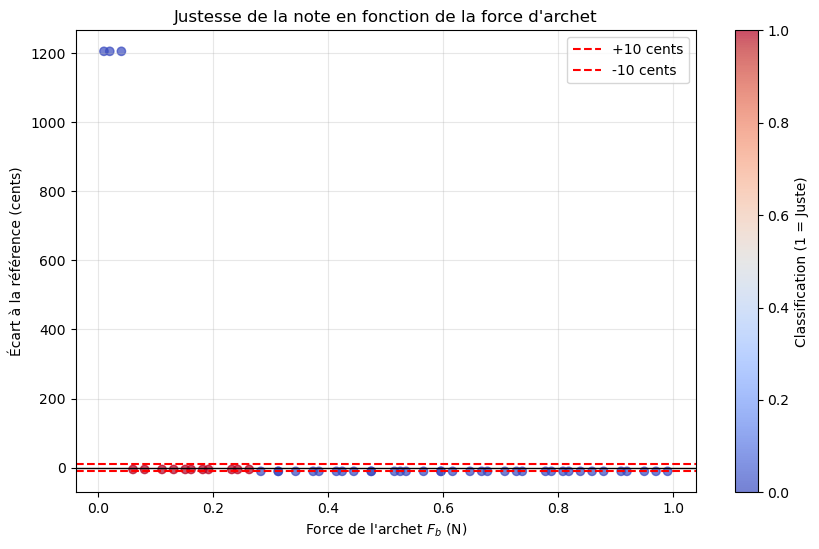

In [44]:
Fb_values = Fb[indexes[:, 0]]

plt.figure(figsize=(10, 6))

# Plot des écarts en cents
plt.scatter(Fb_values, D_note, c=C_justesse, cmap='coolwarm', alpha=0.7)
plt.axhline(y=eps3, color='r', linestyle='--', label=f'+{eps3} cents')
plt.axhline(y=-eps3, color='r', linestyle='--', label=f'-{eps3} cents')
plt.axhline(y=0, color='black', lw=1)

plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel("Écart à la référence (cents)")
plt.title("Justesse de la note en fonction de la force d'archet")
plt.colorbar(label="Classification (1 = Juste)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

simple zoom:

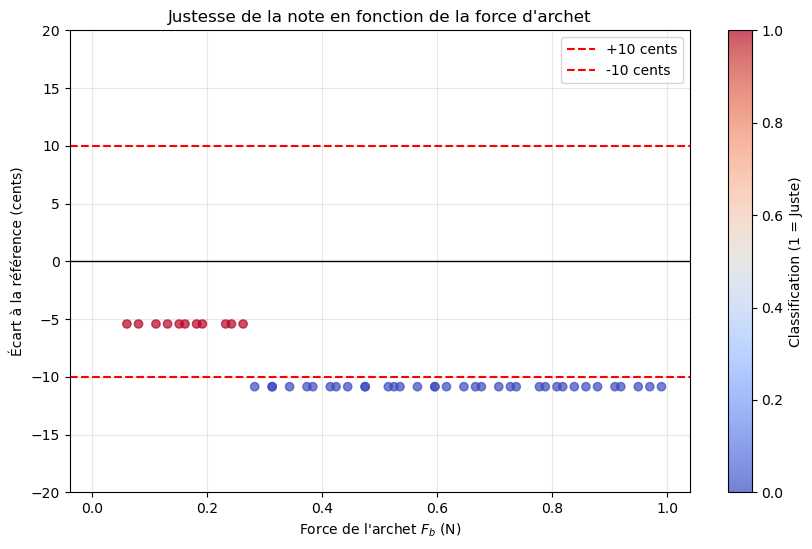

In [45]:
Fb_values = Fb[indexes[:, 0]]

plt.figure(figsize=(10, 6))

# Plot des écarts en cents
plt.scatter(Fb_values, D_note, c=C_justesse, cmap='coolwarm', alpha=0.7)
plt.axhline(y=eps3, color='r', linestyle='--', label=f'+{eps3} cents')
plt.axhline(y=-eps3, color='r', linestyle='--', label=f'-{eps3} cents')
plt.axhline(y=0, color='black', lw=1)

plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel("Écart à la référence (cents)")
plt.title("Justesse de la note en fonction de la force d'archet")
plt.colorbar(label="Classification (1 = Juste)")
plt.ylim((-20, 20))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()